In [43]:
import sys
!{sys.executable} -m pip install scikit-plot

  Using cached https://files.pythonhosted.org/packages/7c/47/32520e259340c140a4ad27c1b97050dd3254fdc517b1d59974d47037510e/scikit_plot-0.3.7-py3-none-any.whl


In [44]:
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import pickle
import os
import numpy as np

In [45]:
def preprocess_tweets(data):
    snow = nltk.stem.SnowballStemmer('english')
    data['description'].dropna(inplace=True)
    for index, sentence in enumerate(data['description']):
        sentence = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', str(sentence))
        sentence = re.sub(r'[?|!|\'|’|"|#|@|_|:|“|”|-|"|-|-|<|>|{|}.|,|)|(|\|/]', r'', sentence)
        sentence = nltk.word_tokenize(sentence)
        words = [snow.stem(word) for word in sentence if word not in stopwords.words('english')]
        data.loc[index, 'description'] = (" ".join(map(str, words)))
    X = data['description']
    return data

In [60]:
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score

def execute_pipeline(cl_type, x_train, x_test, y_train, y_test):
    
    if cl_type == 'svm':
        steps = [('scaler', StandardScaler()), ('SVM', SVC(probability=True))]
        hypertuning_parameters = {'SVM__C': [0.1, 1, 9, 10, 100], 'SVM__gamma': [0.1, 1], 'SVM__kernel': ['linear']}
        label = 'SVM'
        import scikitplot as skplt
    elif cl_type == 'rf':
        steps = [('scaler', StandardScaler()), ('RF', RandomForestClassifier())]
        hypertuning_parameters = {"RF__max_depth": [3, None],
                                 "RF__max_features": [1, 10],
                                 "RF__min_samples_leaf": [1, 3, 10],
                                 "RF__criterion": ["gini", "entropy"]}
        label = 'RANDOM FOREST'
    elif cl_type == 'dt':
        steps = [('scaler', StandardScaler()), ('DT', DecisionTreeClassifier())]
        hypertuning_parameters = {"DT__max_depth": [3, None],
                             "DT__max_features": [1, 10],
                             "DT__min_samples_leaf": [1, 3, 10],
                             "DT__criterion": ["gini", "entropy"]}
        label = 'DECISION TREE'
    elif cl_type == 'lr':
        steps = [('scaler', StandardScaler()), ('LR', LogisticRegression())]
        label = 'LOGISTIC REGRESSION'
        hypertuning_parameters = {}
    
    pipeline = Pipeline(steps)
    
    warnings.simplefilter(action='ignore')
    kfold = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
    clf_model = GridSearchCV(pipeline, param_grid=hypertuning_parameters, cv=kfold)            
    clf_model.fit(x_train, y_train)
    y_pred = clf_model.predict(x_test)

    print('--------------- ', label, '------------------')
    
    print("Accuracy = %3.2f" % (clf_model.score(x_test, y_test)))
    print("Precision = %3.2f" % (precision_score(y_test,y_pred)))
    print("Recall = %3.2f" % (recall_score(y_test,y_pred)))
    print("F1 = %3.2f" % (f1_score(y_test,y_pred)))
    
    from sklearn.metrics import confusion_matrix
    conmat = np.array(confusion_matrix(y_test, y_pred, labels=[1, 0]))
    confusion = pd.DataFrame(conmat, index=['YES', 'NO'], columns=['predicted_YES', 'predicted_NO'])
    print(confusion)
    
    import scikitplot as skplt
    predicted_probas = clf_model.predict_proba(x_test)
    skplt.metrics.plot_roc(y_test, predicted_probas)
    plt.show()

    print('\n')
    
    return clf_model

In [61]:
def export(cl, path):
    """
    convert the classifier to byte representation and save it to a file
    :param path:
    :return:
    """
    try:
        os.remove(path)
    except FileNotFoundError:
        pass

    with open(path, 'wb') as file:
        pickle.dump(cl, file)

In [62]:
def predict_label_and_save(cl):
    test_file_path = 'DownsampledCoreDataForBotTest.csv'
    dataf = pd.read_csv(test_file_path, encoding='utf-8')

    df = preprocess_tweets(dataf)
    df['screen_name_binary'] = any(x in df.screen_name for x in symbols)
    df['description_binary'] = any(x in df.description for x in symbols)

    # Separating observations
    x = df.drop(['bot', 'screen_name', 'description', 'location', 'verified'], axis=1)
    y = df['bot']

    print(x.head())
    
    print("\nClassifying user now...")
    predicted_df = []
    for i in x.itertuples(index=True, name='Pandas'):
        data = np.array(i).reshape(1, -1)
        input_data = np.delete(data, 0, axis=1)
        result = cl.predict(np.nan_to_num(input_data))
        if result[0] == 1:
            dictn = {'id': i.id, 'bot': 1}
            predicted_df.append(dictn)
        else:
            dictn = {'id': i.id, 'bot': 0}
            predicted_df.append(dictn)


    new_df = pd.concat([x, pd.DataFrame(predicted_df)], axis=1)
    print(new_df)

    new_df.to_csv("BotClassificationResults.csv", index=False)

    print("\nClassification done and saved in 'BotClassificationResults.csv'!\n")

Feature engineering for the dataset

In [1]:
symbols = ['Bot', 'bot', 'b0t', 'B0T', 'B0t', 'random', 'http', 'co', 'every', 'twitter', 'pubmed', 'news',
           'created', 'like', 'feed', 'tweeting', 'task', 'world', 'x', 'affiliated', 'latest', 'twitterbot',
           'project', 'botally', 'generated', 'image', 'reply', 'tinysubversions', 'biorxiv', 'digital', 'rt',
           'ckolderup', 'arxiv', 'rss', 'thricedotted', 'collection', 'want', 'backspace', 'maintained',
           'things', 'curated', 'see', 'us', 'people', 'every', 'love', 'please']

train_file_path = 'BotTrainingData.csv'
dataf = pd.read_csv(train_file_path, encoding='utf-8')

# Preprocessing
df = preprocess_tweets(dataf)

# Feature engineering
df['screen_name_binary'] = any(x in df.screen_name for x in symbols)
df['description_binary'] = any(x in df.description for x in symbols)

# Separating observations
x = df.drop(['bot', 'screen_name', 'description', 'id_str', 'std_deviation_friends', 'std_deviation_followers'], axis=1)
y = df['bot']

NameError: name 'pd' is not defined

Check for missingness in data

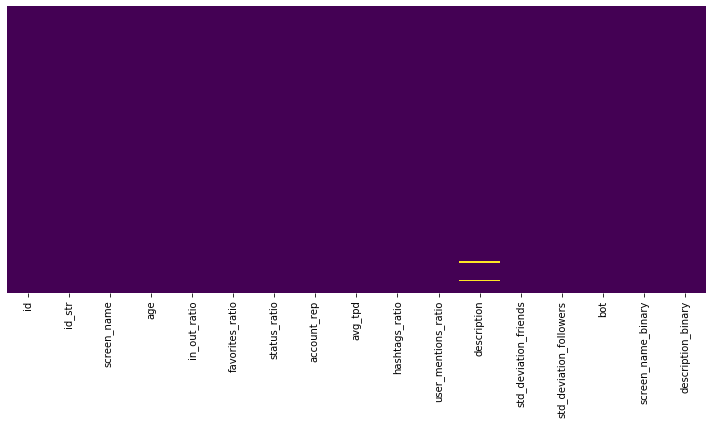

In [64]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
def get_heatmap(df):
    plt.figure(figsize=(10,6))
    sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')
    plt.tight_layout()
    return plt.show()

get_heatmap(df)

We can see that the missing observations are few and only confined to 'description' field.

In [65]:
x.head()

,id,age,in_out_ratio,favorites_ratio,status_ratio,account_rep,avg_tpd,hashtags_ratio,user_mentions_ratio,screen_name_binary,description_binary
0,4303727112,8.862112e+07,1.000000,0.000000,1.130927,1.000000,3.558719,0.000,0.000,False,False
1,3063139353,1.117717e+08,1.000000,0.000000,1.297874,1.000000,2.577320,0.000,0.000,False,False
2,545449655,2.032409e+08,2.024242,0.814088,1.357381,0.669339,4.032258,0.543,0.653,False,False
3,9624742,3.436636e+08,11403.366890,0.006034,14.221180,0.999912,10.869565,0.908,1.689,False,False
4,4180417402,8.926193e+07,4.761905,0.012583,23.229540,0.826446,23.809524,0.000,0.000,False,False


---------------  DECISION TREE ------------------
Accuracy = 0.86
Precision = 0.93
Recall = 0.77
F1 = 0.84
     predicted_YES  predicted_NO
YES             27             8
NO               2            33


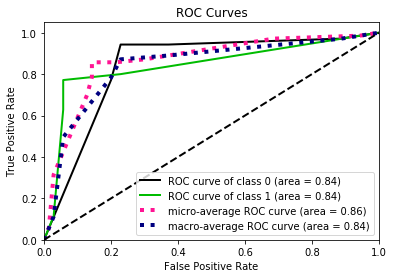



---------------  RANDOM FOREST ------------------
Accuracy = 0.80
Precision = 0.86
Recall = 0.71
F1 = 0.78
     predicted_YES  predicted_NO
YES             25            10
NO               4            31


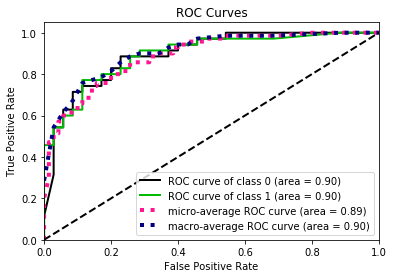



---------------  SVM ------------------
Accuracy = 0.79
Precision = 0.83
Recall = 0.71
F1 = 0.77
     predicted_YES  predicted_NO
YES             25            10
NO               5            30


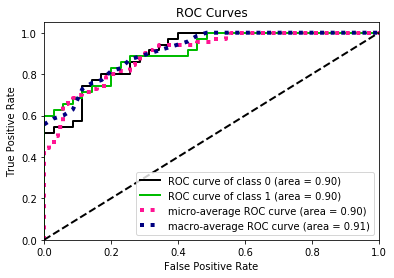



---------------  LOGISTIC REGRESSION ------------------
Accuracy = 0.79
Precision = 0.81
Recall = 0.74
F1 = 0.78
     predicted_YES  predicted_NO
YES             26             9
NO               6            29


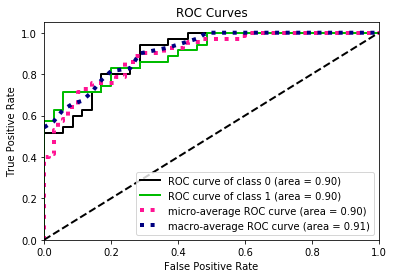

In [74]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=30, stratify=y)

export(execute_pipeline('dt', x_train, x_test, y_train, y_test), 'trained_dt.p')
export(execute_pipeline('rf', x_train, x_test, y_train, y_test), 'trained_rf.p')
export(execute_pipeline('svm', x_train, x_test, y_train, y_test), 'trained_svm.p')
export(execute_pipeline('lr', x_train, x_test, y_train, y_test), 'trained_lr.p')

---------------  DECISION TREE ------------------
Accuracy = 0.81
Precision = 0.89
Recall = 0.71
F1 = 0.79
     predicted_YES  predicted_NO
YES             25            10
NO               3            32


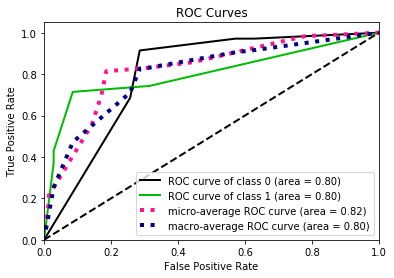



           id           age  in_out_ratio  favorites_ratio  status_ratio  \
0   259570426  2.691286e+08      0.748899         0.063886      0.269670   
1   379554483  2.512463e+08      1.657407         7.052063     54.546797   
2    20681749  3.337197e+08      0.600708        36.695957     79.228553   
3   970451120  2.143042e+08      0.603175         0.414454      4.695262   
4  2277635479  1.792401e+08      1.079659         9.005376     28.362451   

   account_rep     avg_tpd  hashtags_ratio  user_mentions_ratio  \
0     0.428212    1.849438        0.619684               1.0887   
1     0.623693   13.698630        0.210000               1.3860   
2     0.375276  200.000000        0.185000               1.4170   
3     0.376238    4.366812        0.054000               1.1790   
4     0.519152    8.849558        0.324000               1.2700   

   screen_name_binary  description_binary  
0               False               False  
1               False               False  
2     

In [75]:
cl = execute_pipeline('dt', x_train, x_test, y_train, y_test)
predict_label_and_save(cl)

In [76]:
result_file_path = 'BotClassificationResults.csv'
dataf = pd.read_csv(result_file_path, encoding='utf-8')

In [77]:
dataf.head()

,id,age,in_out_ratio,favorites_ratio,status_ratio,account_rep,avg_tpd,hashtags_ratio,user_mentions_ratio,screen_name_binary,description_binary,id.1,bot
0,259570426,2.691286e+08,0.748899,0.063886,0.269670,0.428212,1.849438,0.619684,1.0887,False,False,259570426,0
1,379554483,2.512463e+08,1.657407,7.052063,54.546797,0.623693,13.698630,0.210000,1.3860,False,False,379554483,0
2,20681749,3.337197e+08,0.600708,36.695957,79.228553,0.375276,200.000000,0.185000,1.4170,False,False,20681749,0
3,970451120,2.143042e+08,0.603175,0.414454,4.695262,0.376238,4.366812,0.054000,1.1790,False,False,970451120,0
4,2277635479,1.792401e+08,1.079659,9.005376,28.362451,0.519152,8.849558,0.324000,1.2700,False,False,2277635479,0


In [78]:
dataf['bot'].value_counts()

0    329
1     58
Name: bot, dtype: int64

# Results
* Labeled "62" users from the annotated dataset as 'bots'.
* Next, we proceed to remove these bot accounts from the annotated dataset for further steps.